In [6]:
import re
import sklearn
import numpy as np
import pandas as pd
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.models import Item
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)


In [63]:
# Make a list of most frequent brands of the form 'BCBG', 'BCBGMAXAZRIA','Alice + Olivia', etc...
top_brands_query = "SELECT brand, count(brand) FROM items WHERE brand != 'LENDER SUBMISSION FILL IN' AND rent_per_week < 1000 GROUP BY brand ORDER BY count(brand) DESC;"
top_brand_df = pd.read_sql_query(top_brands_query, engine)
top_brands = ["\'{}\'".format(brand.replace("'", "''")) for brand in top_brand_df['brand']]
top_brands = ', '.join(top_brands)

<function TextIOWrapper.close>

In [20]:
#query = "SELECT brand, item_type, cost, rent_per_week FROM items WHERE brand in ({}) AND rent_per_week < 600".format(top_brands)
#df = pd.read_sql_query(query, engine)
df = ml_model.canonical_df

# get one-hot columns for brands 
dummy_brands = pd.get_dummies(df['brand'])
df = pd.concat([df, dummy_brands], axis = 1)

df = df.drop('brand', axis = 1)

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
df = pd.concat([df, dummified_items], axis = 1)
df = df.drop('item_type', axis = 1)
df_brands = df

In [58]:
# get list of adjective features form database
features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]
item_types   = [item.name for item in dbsession.query(ItemType).all()]

df = ml_model.canonical_df
parse_title.create_one_hot_row_adj('chiffon mini', features_adj)
df['title'].values
tokenized_titles = []
for title in df['title']:
    parse_title.create_one_hot_row_adj(title, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

In [60]:
df_full = pd.concat([df_brands, df_adj], axis = 1)

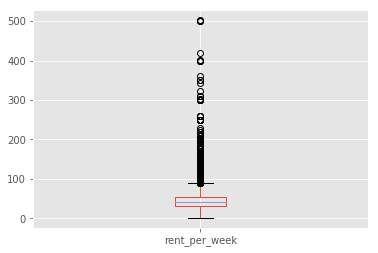

In [77]:
df.boxplot('rent_per_week')

In [24]:
# split data into train and test group
df = df_full
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]

print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:', len(test))

Number of observations in the training data: 4272
Number of observations in the test data: 1490


In [ ]:
y = train['rent_per_week']
features = df_full.columns.drop(['rent_per_week', 'title']) # just column names

In [ ]:
import sys
sys.stdout=open("test.txt","w")
print(df_full)
sys.stdout.close()

In [ ]:
clf = RandomForestRegressor()
clf.fit(train[features], train['rent_per_week'])
#joblib.dump(clf, 'rfr_v0.2.pkl')
#call this with: clf = joblib.load('rfr_v0.2.pkl')

In [ ]:
rfr_predicted = clf.predict(test[features]).astype(int)
fig, ax = plt.subplots(figsize=(20, 10))
y = test['rent_per_week']
print(test['rent_per_week'].max())
ax.scatter(x = test['rent_per_week'], y = rfr_predicted)
ax.plot([0, 200], [0, 200], 'k--', lw=4)
ax.set_xlabel('Measured', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)
y.max()